<a id="TOP"></a>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/60/NISAR_artist_concept.jpg" width=150/><img src="https://upload.wikimedia.org/wikipedia/commons/9/9b/NISAR_Mission_Logo.png" width=200/> 

***

# NASA ISRO Synthetic Aperture Radar Mission
## Query and Download from ASF DAAC (disabled until NISAR data on ASF)
## Preprocess NISAR-simulated ALOS2 products 
#### This notebook uses a stack of GCOV products that were created with the notebook: Ecosystems_InputPrep_ALOS2-NISAR.ipynb. The files were uploaded to the scratch space. 

Authors: Alex Christensen


## 1 &emsp; Import Python Modules

In [125]:
import os
from pathlib import Path

import sys

# notebook_dir = Path(os.getcwd())
notebook_dir = Path('/scratch/alex_eco_test/')
main_dir = notebook_dir.resolve().parents[0]
aoi = 'southfork'
aoi_dir = notebook_dir/aoi
Path(aoi).mkdir(parents=True,exist_ok=True)

print(notebook_dir)
import rasterio.mask


/scratch/alex_eco_test


In [126]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from osgeo import gdal, osr, ogr
import subprocess

import time
import scipy
import pandas as pd
from pandas import DataFrame
from IPython.display import Image
import sklearn  # imported from scikit-learn
from sklearn import metrics
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap
%matplotlib inline
import rasterio

# from ipywidgets import interactive
from rasterio.plot import show_hist

# import asf_search as asf
import geopandas as gpd
from shapely.geometry import shape, Polygon

# from ipyleaflet import (
#     Map,  basemaps,
#     Rectangle,
#     GeoJSON,
#     DrawControl,GeoData
# )
# import ipyleaflet
import h5py

In [127]:
input_dir = aoi_dir / 'GCOV'
output_dir = aoi_dir / 'outputs'
# ancillary_dir = main_dir / 'ancillary_data'
Path(input_dir).mkdir(parents=True, exist_ok=True)
Path(output_dir).mkdir(parents=True, exist_ok=True)




## 2:  Set the Query Parameters

## 2.1: Define the AOI
Provide either a geojson defining the AOI or draw one on the map

In [6]:
# m = Map(basemap=basemaps.Esri.WorldImagery, center=(0,0), zoom=2)
# # poly_color = '#00F'
# draw_control = DrawControl()

# draw_control.rectangle = {"shapeOptions": {"fillColor": "#fca45d", "color": "#fca45d", "fillOpacity": 1.0 }}

# def clear_m():
#     global rects,polys
#     rects = set()
#     polys = set()

# clear_m()
# def handle_draw(self, action, geo_json):
#     global rects,polys
#     polygon=[]
#     for coords in geo_json['geometry']['coordinates'][0][:-1][:]:
#         polygon.append(tuple(coords))
#     polygon = tuple(polygon)
#     if geo_json['properties']['style']['color'] == '#00F':  # poly
#         if action == 'created':
#             polys.add(polygon)
#         elif action == 'edited':
#             #polys.update(polygon)
#             polys.clear()
#             polys.add(polygon)
#         elif action == 'deleted':
#             polys.discard(polygon)

# draw_control.on_draw(handle_draw)
# m.add_control(draw_control)
  
# m

In [7]:
# if os.path.isfile('%s.geojson' %(aoi_inputs/aoi))==False:
#     polygon: Polygon = shape(draw_control.last_draw.get('geometry'))
#     polygon.geom_type
#     print(polygon)
#     poly_df = gpd.GeoDataFrame(geometry=[polygon],crs='epsg:4326')
#     poly_df.to_file('%s.geojson' %(aoi_inputs/aoi),driver='GeoJSON')
# else:
#     gdf = gpd.read_file('%s.geojson' %(aoi_inputs/aoi))
#     polygon = gdf.geometry[0]

# wkt = str(polygon)


## 2.2: Define the search query for NISAR data
Options (more options and details are available here: https://docs.asf.alaska.edu/api/keywords/)
- platform
- instrument
- frame
- processinglevel
- flightDirection
- start
- end
- maxResults

In [8]:
# opts = {
#     'platform':asf.PLATFORM.SENTINEL1,
#     'processingLevel': asf.PRODUCT_TYPE.GRD_HD,
#     'flightDirection':asf.FLIGHT_DIRECTION.ASCENDING,
#     'start':'Feb 12, 2017',
#     'end':'December 11, 2017',
#     # 'maxResults':5
#     }

## 2.3: Submit search and decide whether or not to download


In [9]:
# results = asf.geo_search(intersectsWith=wkt, **opts)
# print(f'{len(results)} results found')


## 2.4: Download files.
You must enter your ASF/EarthData login credentials

In [10]:
# ## Change to True if you want to download all of the results. Otherwise, adjust search query before continuing
# download = False
# if download:
#     session = asf.ASFSession().auth_with_creds('achri', '**')
#     results.download(path=aoi_dir, session=session)
# else:
#     print('Not downloading yet')

## 3: Preprocess GCOV products

## 3.1: Find, unzip, and open HDF5 files

In [7]:
# from s3path import PureS3Path
# import s3fs
# import glob
# import os
# import h5py
# s3 = s3fs.S3FileSystem(anon=False)

# # s3.glob(indir + 'LED-ALOS2*1.1__*')

In [169]:
h5_files = glob.glob(str(input_dir/ '*gcov.h5'))
# h5_files = s3.glob(str(aoi_inputs/ 'GCOV*.h5'))
print(*h5_files,sep='\n')


/scratch/alex_eco_test/southfork/GCOV/0000486388_001001_ALOS2453940840-221019_gcov.h5
/scratch/alex_eco_test/southfork/GCOV/0000505514_001001_ALOS2474640840-230308_gcov.h5
/scratch/alex_eco_test/southfork/GCOV/0000472776_001001_ALOS2435310840-220615_gcov.h5
/scratch/alex_eco_test/southfork/GCOV/0000499756_001001_ALOS2466360840-230111_gcov.h5
/scratch/alex_eco_test/southfork/GCOV/0000510241_001001_ALOS2480850840-230419_gcov.h5
/scratch/alex_eco_test/southfork/GCOV/0000473049_001001_ALOS2437380840-220629_gcov.h5
/scratch/alex_eco_test/southfork/GCOV/0000517838_001001_ALOS2489130840-230614_gcov.h5
/scratch/alex_eco_test/southfork/GCOV/0000470073_001001_ALOS2427030840-220420_gcov.h5
/scratch/alex_eco_test/southfork/GCOV/0000532666_001001_ALOS2505690840-231004_gcov.h5
/scratch/alex_eco_test/southfork/GCOV/0000511819_001001_ALOS2482920840-230503_gcov.h5
/scratch/alex_eco_test/southfork/GCOV/0000506843_001001_ALOS2476710840-230322_gcov.h5
/scratch/alex_eco_test/southfork/GCOV/0000493581_00100

39

In [170]:
## clean up previously processed geotiffs
clean = True
if clean:
    old_files = glob.glob('%s/*.tif' %(output_dir))
    for i in range(len(old_files)):
        os.system('rm -r %s' %(old_files[i]))


0000486388_001001_ALOS2453940840-221019_gcov.h5
Raster bounds:  -93.49443383772795 -92.52387828217232 41.91186210337758 42.63713988115541
X Size:  3495  Y Size:  2612
Resolution:  0.00027777777777515666 m



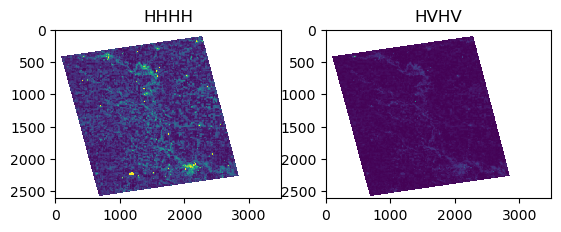

0000505514_001001_ALOS2474640840-230308_gcov.h5
Raster bounds:  -93.49611356779286 -92.52555801223723 41.91160406721518 42.63688184499301
X Size:  3495  Y Size:  2612
Resolution:  0.00027777777777515666 m



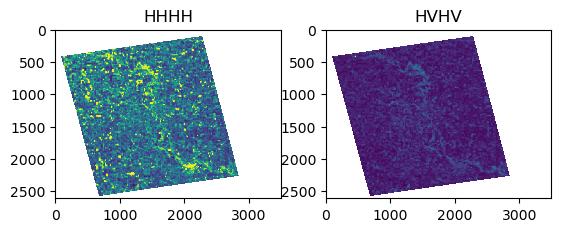

0000472776_001001_ALOS2435310840-220615_gcov.h5
Raster bounds:  -93.49429215270288 -92.52401437492503 41.91178502884043 42.63706280661826
X Size:  3494  Y Size:  2612
Resolution:  0.00027777777777515666 m



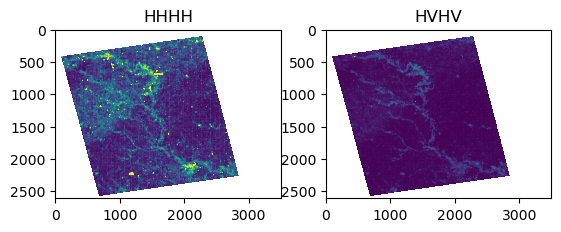

0000499756_001001_ALOS2466360840-230111_gcov.h5
Raster bounds:  -93.49092733792945 -92.52287178237381 41.91210708459297 42.637107084593026
X Size:  3486  Y Size:  2611
Resolution:  0.00027777777777515666 m



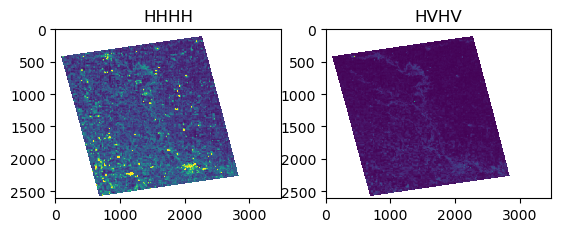

0000510241_001001_ALOS2480850840-230419_gcov.h5
Raster bounds:  -93.49256041485326 -92.5222826370754 41.91184321256644 42.63712099034427
X Size:  3494  Y Size:  2612
Resolution:  0.00027777777777515666 m



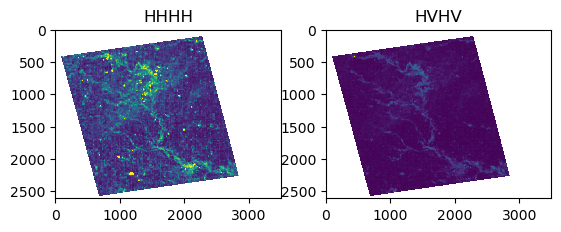

0000473049_001001_ALOS2437380840-220629_gcov.h5
Raster bounds:  -93.49652486215594 -92.5259693066003 41.91167122773458 42.63694900551241
X Size:  3495  Y Size:  2612
Resolution:  0.00027777777777515666 m



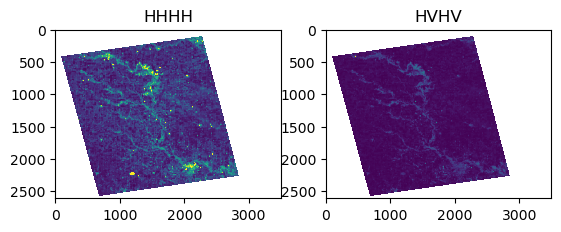

0000517838_001001_ALOS2489130840-230614_gcov.h5
Raster bounds:  -93.49349384543908 -92.52293828988344 41.911704937183416 42.63698271496125
X Size:  3495  Y Size:  2612
Resolution:  0.00027777777777515666 m



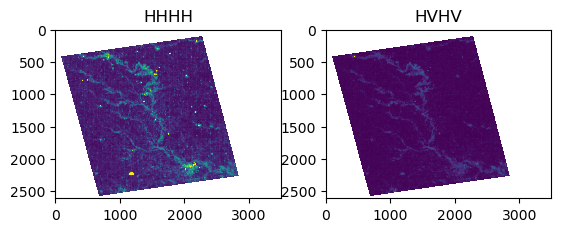

0000470073_001001_ALOS2427030840-220420_gcov.h5
Raster bounds:  -93.4932477169866 -92.52269216143097 41.911848396062105 42.63712617383994
X Size:  3495  Y Size:  2612
Resolution:  0.00027777777777515666 m



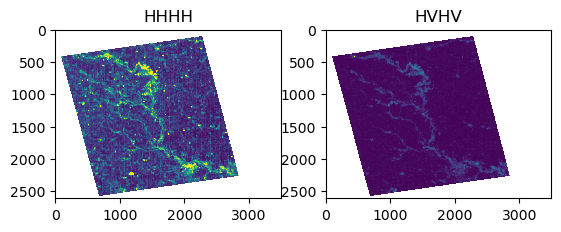

0000532666_001001_ALOS2505690840-231004_gcov.h5
Raster bounds:  -93.49306265287474 -92.5250070973191 41.91191630724909 42.63691630724915
X Size:  3486  Y Size:  2611
Resolution:  0.00027777777777515666 m



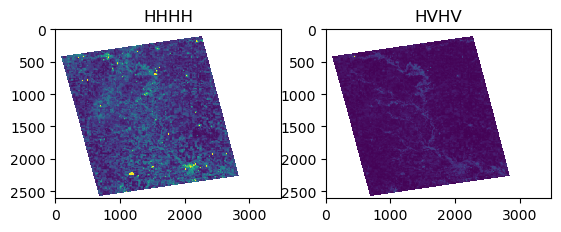

0000511819_001001_ALOS2482920840-230503_gcov.h5
Raster bounds:  -93.4952895683769 -92.52473401282127 41.91170822866987 42.63698600644771
X Size:  3495  Y Size:  2612
Resolution:  0.00027777777777515666 m



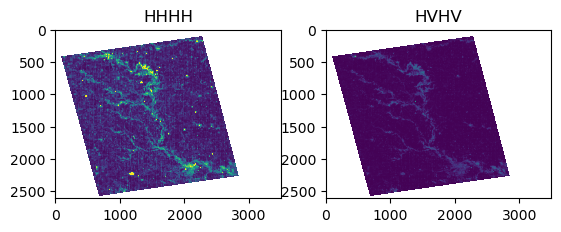

0000506843_001001_ALOS2476710840-230322_gcov.h5
Raster bounds:  -93.49036784180277 -92.52009006402491 41.911940661464364 42.6372184392422
X Size:  3494  Y Size:  2612
Resolution:  0.00027777777777515666 m



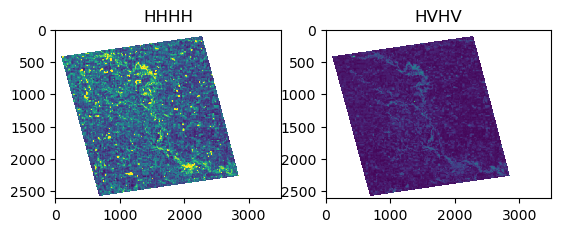

0000493581_001001_ALOS2460150840-221130_gcov.h5
Raster bounds:  -93.49296564794881 -92.52268787017096 41.91201720627009 42.63729498404793
X Size:  3494  Y Size:  2612
Resolution:  0.00027777777777515666 m



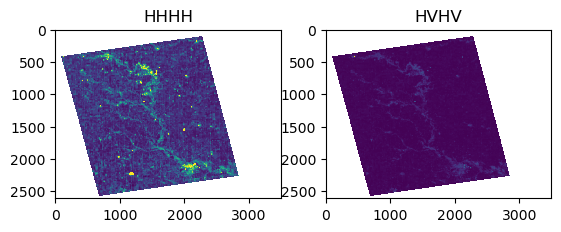

0000480752_001001_ALOS2447730840-220907_gcov.h5
Raster bounds:  -93.49349679878594 -92.52321902100809 41.911942145994225 42.63721992377206
X Size:  3494  Y Size:  2612
Resolution:  0.00027777777777515666 m



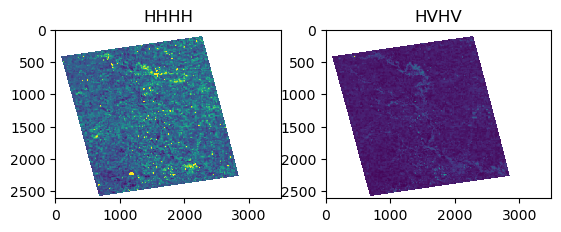

0000521694_001001_ALOS2493270840-230712_gcov.h5
Raster bounds:  -93.49534189509839 -92.52506411732054 41.911796613108194 42.63707439088603
X Size:  3494  Y Size:  2612
Resolution:  0.00027777777777515666 m



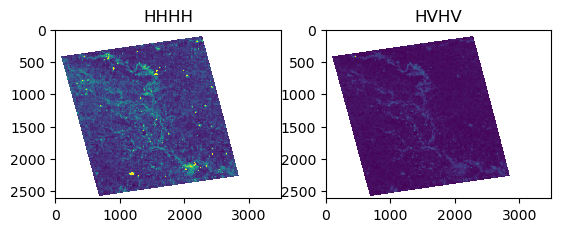

0000503165_001001_ALOS2470500840-230208_gcov.h5
Raster bounds:  -93.4928955417661 -92.52233998621047 41.911754046730906 42.63703182450874
X Size:  3495  Y Size:  2612
Resolution:  0.00027777777777515666 m



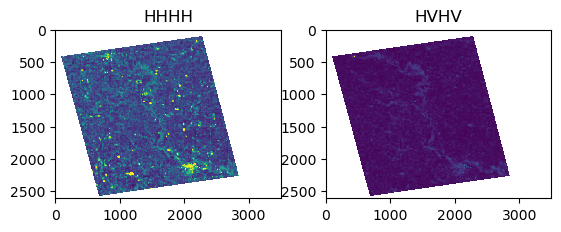

0000526555_001001_ALOS2497410840-230809_gcov.h5
Raster bounds:  -93.49192756051819 -92.52387200496256 41.911850261382504 42.63685026138256
X Size:  3486  Y Size:  2611
Resolution:  0.00027777777777515666 m



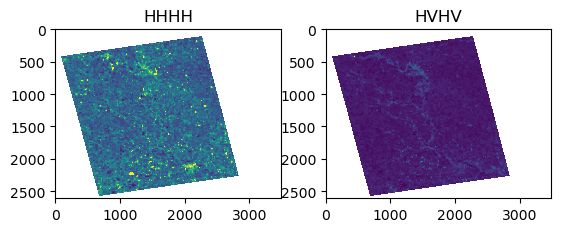

0000471229_001001_ALOS2431170840-220518_gcov.h5
Raster bounds:  -93.49395743601274 -92.52367965823488 41.911748549521356 42.63702632729919
X Size:  3494  Y Size:  2612
Resolution:  0.00027777777777515666 m



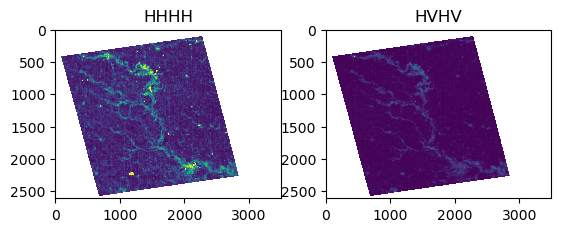

0000519712_001001_ALOS2491200840-230628_gcov.h5
Raster bounds:  -93.49374330349076 -92.52346552571291 41.911670496897436 42.63694827467527
X Size:  3494  Y Size:  2612
Resolution:  0.00027777777777515666 m



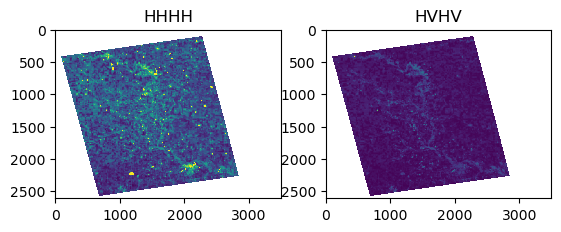

0000501936_001001_ALOS2468430840-230125_gcov.h5
Raster bounds:  -93.49091984273925 -92.52286428718361 41.91209310599415 42.63709310599421
X Size:  3486  Y Size:  2611
Resolution:  0.00027777777777515666 m



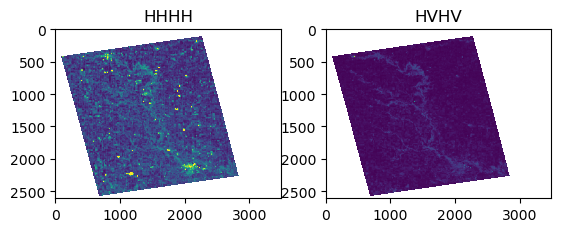

0000469570_001001_ALOS2424960840-220406_gcov.h5
Raster bounds:  -93.49137552805594 -92.52109775027809 41.912104934124535 42.63738271190237
X Size:  3494  Y Size:  2612
Resolution:  0.00027777777777515666 m



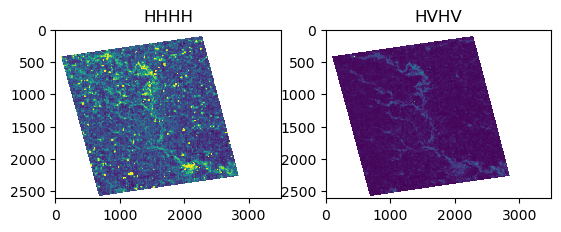

0000531054_001001_ALOS2503620840-230920_gcov.h5
Raster bounds:  -93.49094322500932 -92.52288766945368 41.91189993017636 42.63689993017642
X Size:  3486  Y Size:  2611
Resolution:  0.00027777777777515666 m



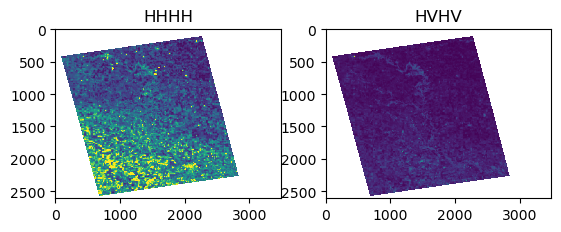

0000483019_001001_ALOS2449800840-220921_gcov.h5
Raster bounds:  -93.49309178340593 -92.5250362278503 41.911993487516405 42.63699348751646
X Size:  3486  Y Size:  2611
Resolution:  0.00027777777777515666 m



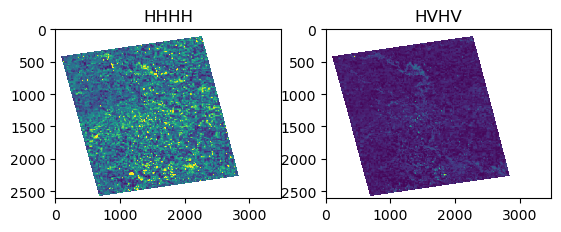

0000504382_001001_ALOS2472570840-230222_gcov.h5
Raster bounds:  -93.4916128724168 -92.52133509463894 41.911902423111364 42.6371802008892
X Size:  3494  Y Size:  2612
Resolution:  0.00027777777777515666 m



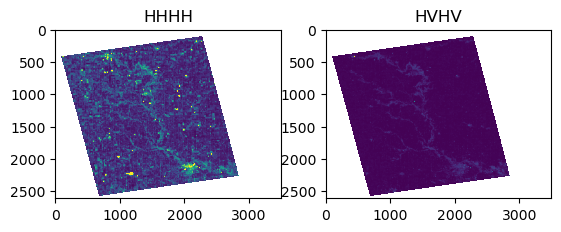

0000495714_001001_ALOS2462220840-221214_gcov.h5
Raster bounds:  -93.49423783811974 -92.52368228256411 41.91183659469209 42.637114372469924
X Size:  3495  Y Size:  2612
Resolution:  0.00027777777777515666 m



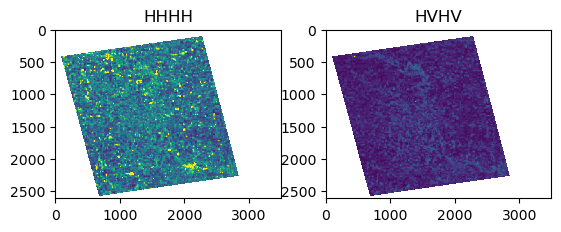

0000497486_001001_ALOS2464290840-221228_gcov.h5
Raster bounds:  -93.49431196646147 -92.52375641090583 41.911943039931764 42.6372208177096
X Size:  3495  Y Size:  2612
Resolution:  0.00027777777777515666 m



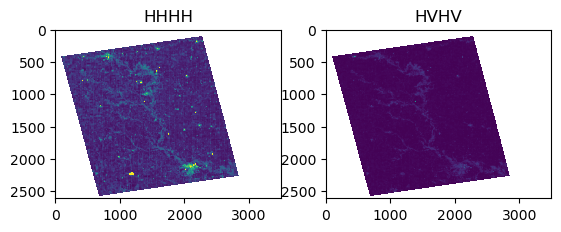

0000484607_001001_ALOS2451870840-221005_gcov.h5
Raster bounds:  -93.49312384147228 -92.52256828591665 41.91187759721132 42.637155374989156
X Size:  3495  Y Size:  2612
Resolution:  0.00027777777777515666 m



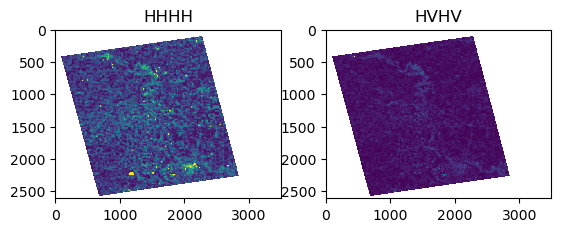

0000514846_001001_ALOS2484990840-230517_gcov.h5
Raster bounds:  -93.49363096680777 -92.52307541125214 41.91170862059405 42.63698639837188
X Size:  3495  Y Size:  2612
Resolution:  0.00027777777777515666 m



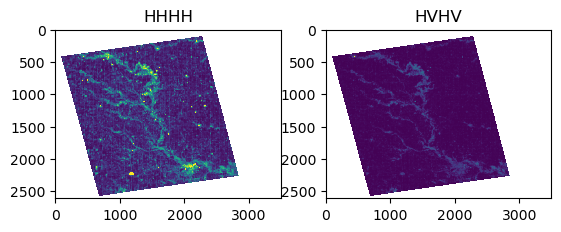

0000461057_001001_ALOS2410470840-211229_gcov.h5
Raster bounds:  -93.49262251102188 -92.52234473324403 41.91210251841309 42.637380296190926
X Size:  3494  Y Size:  2612
Resolution:  0.00027777777777515666 m



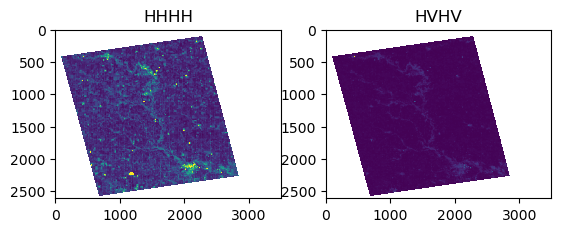

0000461060_001001_ALOS2406330840-211201_gcov.h5
Raster bounds:  -93.49456251138022 -92.52400695582459 41.91181706795225 42.63709484573008
X Size:  3495  Y Size:  2612
Resolution:  0.00027777777777515666 m



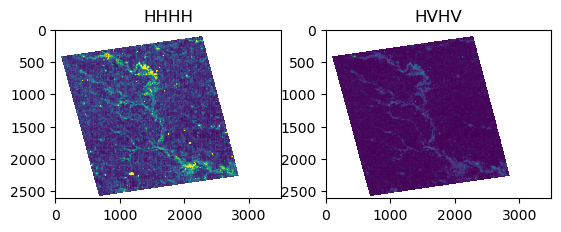

0000524097_001001_ALOS2495340840-230726_gcov.h5
Raster bounds:  -93.49225005759867 -92.52419450204303 41.91189243380161 42.63689243380167
X Size:  3486  Y Size:  2611
Resolution:  0.00027777777777515666 m



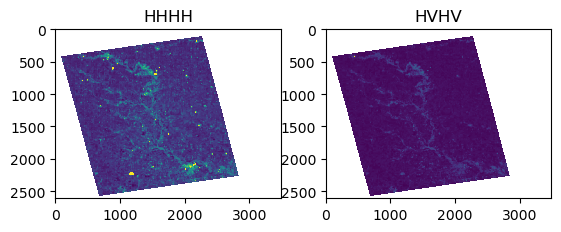

0000462195_001001_ALOS2414610840-220126_gcov.h5
Raster bounds:  -93.49243993542419 -92.52188437986855 41.91196232656328 42.63724010434111
X Size:  3495  Y Size:  2612
Resolution:  0.00027777777777515666 m



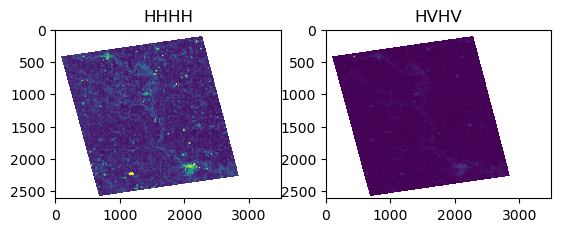

0000516588_001001_ALOS2487060840-230531_gcov.h5
Raster bounds:  -93.49324243905306 -92.52296466127521 41.91169582542779 42.636973603205625
X Size:  3494  Y Size:  2612
Resolution:  0.00027777777777515666 m



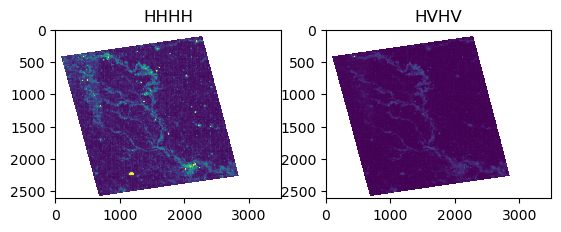

0000474580_001001_ALOS2439450840-220713_gcov.h5
Raster bounds:  -93.49422332380045 -92.52616776824482 41.91191131366775 42.63691131366781
X Size:  3486  Y Size:  2611
Resolution:  0.00027777777777515666 m



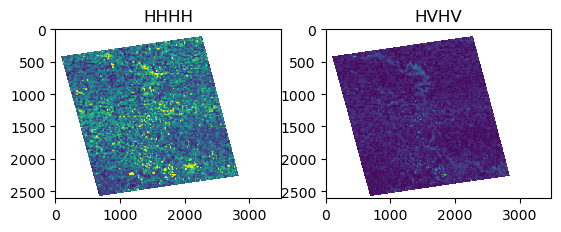

0000462196_001001_ALOS2412540840-220112_gcov.h5
Raster bounds:  -93.49140120031733 -92.52334564476169 41.91212012689847 42.63712012689853
X Size:  3486  Y Size:  2611
Resolution:  0.00027777777777515666 m



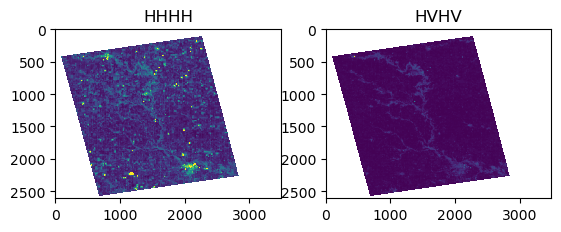

0000474962_001001_ALOS2441520840-220727_gcov.h5
Raster bounds:  -93.4933649576072 -92.52530940205156 41.91192021044727 42.63692021044733
X Size:  3486  Y Size:  2611
Resolution:  0.00027777777777515666 m



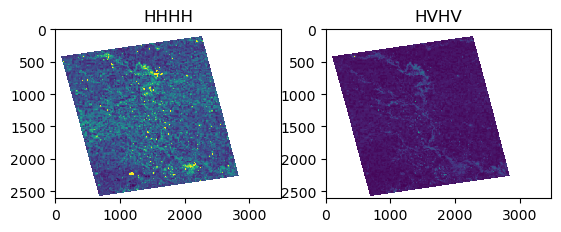

0000527820_001001_ALOS2499480840-230823_gcov.h5
Raster bounds:  -93.49246729436047 -92.52218951658261 41.911812325345274 42.63709010312311
X Size:  3494  Y Size:  2612
Resolution:  0.00027777777777515666 m



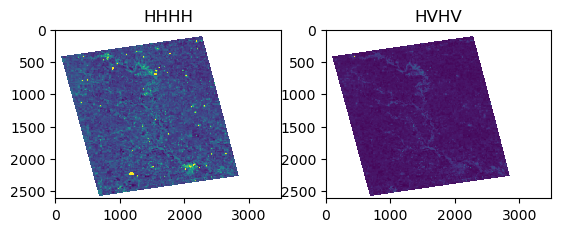

0000487638_001001_ALOS2456010840-221102_gcov.h5
Raster bounds:  -93.49375507050588 -92.52319951495025 41.911907079493346 42.63718485727118
X Size:  3495  Y Size:  2612
Resolution:  0.00027777777777515666 m



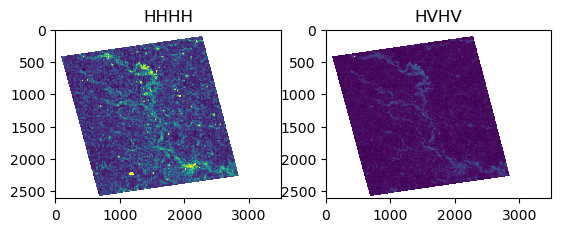

0000507907_001001_ALOS2478780840-230405_gcov.h5
Raster bounds:  -93.49223977924004 -92.52196200146219 41.91184914717089 42.637126924948724
X Size:  3494  Y Size:  2612
Resolution:  0.00027777777777515666 m



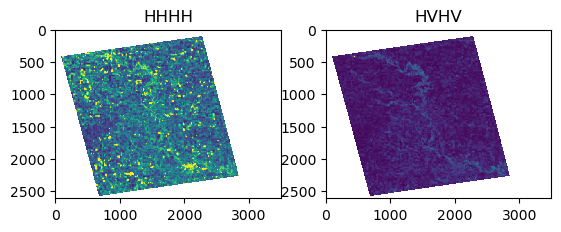

0000478941_001001_ALOS2445660840-220824_gcov.h5
Raster bounds:  -93.49518832303058 -92.52491054525272 41.911771041753454 42.63704881953129
X Size:  3494  Y Size:  2612
Resolution:  0.00027777777777515666 m



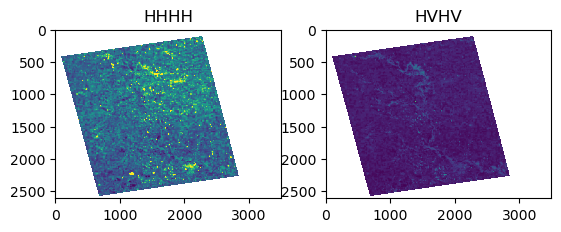

In [171]:
for i in range(len(h5_files)):
    filename = h5_files[i].split('/')[-1].split('_')
    startdate = filename[-1][:-4]
    # enddate = filename[-6]
    
    # f = h5py.File(s3.open(h5_files[i], "rb"))
    f = h5py.File(h5_files[i], "r") 
    a_group_key = list(f.keys())[0]
    ds_x = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['xCoordinates'][()]      # returns as a h5py dataset object
    ds_y = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['yCoordinates'][()]      # returns as a h5py dataset object
    ds_epsg = f[a_group_key]['LSAR']['GCOV']['metadata']['radarGrid']['epsg']
    ds_HHHH = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['HHHH'][()]  # returns as a numpy array
    ds_HVHV = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['HVHV'][()]  # returns as a numpy array
    
    print(h5_files[i].split('/')[-1])
    # print('Dates: ', startdate, ' - ',enddate)
    print('Raster bounds: ',min(ds_x),max(ds_x),min(ds_y),max(ds_y))
    print('X Size: ',ds_x.shape[0],' Y Size: ',ds_y.shape[0])
    print('Resolution: ', ds_y[0] - ds_y[1],'m')
    print('')
    meta = {'driver': 'GTiff', 
            'dtype': 'float32', 
            'nodata': None, 
            'width': ds_x.shape[0], 
            'height': ds_y.shape[0], 
            'count': 1, 
            'crs': rasterio.CRS.from_epsg(ds_epsg[()]), 
            'transform': rasterio.Affine(ds_x[1] - ds_x[0], 0.0, ds_x[0], 0.0, ds_y[1] - ds_y[0], ds_y[0]), 
            'tiled': False, 
            'interleave': 'band'}
    fig,[ax1,ax2] = plt.subplots(ncols=2)
    ax1.imshow(ds_HHHH,vmin=0,vmax=0.2)
    ax1.set_title('HHHH')
    ax2.imshow(ds_HVHV,vmin=0,vmax=0.1)
    ax2.set_title('HVHV')
    plt.show()
    with rasterio.open('%s_HHHH.tif' %(output_dir/h5_files[i].split('/')[-1][:-3]), 'w', **meta) as dst:
            dst.write(ds_HHHH,indexes=1)    
    with rasterio.open('%s_HVHV.tif' %(output_dir/h5_files[i].split('/')[-1][:-3]), 'w', **meta) as dst:
        dst.write(ds_HVHV,indexes=1)    

    

## 3.2: Crop reference image and resample/coregister all images in stack

In [172]:
crop = False
if crop:
    crop_to = gpd.read_file(glob.glob(str(aoi_dir/ '*.geojson'))[0])
    crop_to = crop_to.to_crs(rasterio.CRS.from_epsg(ds_epsg[()]))

    crop_to.plot()
    crop_to = crop_to.explode()
    shapes = crop_to.geometry
    
   

In [173]:
tif_files = glob.glob('%s/*.tif' %(output_dir))
if crop:
    with rasterio.open(tif_files[0]) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=crop)
        ref_meta = src.meta

    ref_meta.update({"driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform})
else:
    with rasterio.open(tif_files[0]) as src:
        out_image = src.read()
        out_transform = src.transform
        ref_meta = src.meta
        
with rasterio.open('%s_subset.tif' %(tif_files[0][:-4]), "w", **ref_meta) as dest:
    dest.write(out_image)

with rasterio.open('%s_subset.tif' %(tif_files[0][:-4])) as src:
    ref_te = src.bounds
    ref_tr = out_transform[0]

len(tif_files)

['/scratch/alex_eco_test/southfork/outputs/0000527820_001001_ALOS2499480840-230823_gcov_HVHV.tif',
 '/scratch/alex_eco_test/southfork/outputs/0000487638_001001_ALOS2456010840-221102_gcov_HVHV.tif',
 '/scratch/alex_eco_test/southfork/outputs/0000516588_001001_ALOS2487060840-230531_gcov_HHHH.tif',
 '/scratch/alex_eco_test/southfork/outputs/0000462195_001001_ALOS2414610840-220126_gcov_HHHH.tif',
 '/scratch/alex_eco_test/southfork/outputs/0000507907_001001_ALOS2478780840-230405_gcov_HVHV.tif',
 '/scratch/alex_eco_test/southfork/outputs/0000524097_001001_ALOS2495340840-230726_gcov_HHHH.tif',
 '/scratch/alex_eco_test/southfork/outputs/0000461057_001001_ALOS2410470840-211229_gcov_HHHH.tif',
 '/scratch/alex_eco_test/southfork/outputs/0000461060_001001_ALOS2406330840-211201_gcov_HHHH.tif',
 '/scratch/alex_eco_test/southfork/outputs/0000478941_001001_ALOS2445660840-220824_gcov_HVHV.tif',
 '/scratch/alex_eco_test/southfork/outputs/0000514846_001001_ALOS2484990840-230517_gcov_HHHH.tif',
 '/scratch

In [177]:
for i in range(len(tif_files)):
    os.system('gdalwarp -overwrite -tr %s %s -te %s %s %s %s -tap -srcnodata nan -dstnodata nan %s %s_subset_coreg.tif' %(ref_tr,ref_tr,ref_te.left,ref_te.bottom,ref_te.right,ref_te.top,tif_files[i],tif_files[i][:-4]))
    # os.system('gdalwarp -overwrite -tr %s %s -te %s %s %s %s -tap -srcnodata nan -dstnodata nan %s_HVHV.tif %s_HVHV_subset_coreg.tif'  %(ref_tr,ref_tr,ref_te.left,ref_te.bottom,ref_te.right,ref_te.top,h5_files[i][:-4],h5_files[i][:-4]))


Creating output file that is 3495P x 2613L.
Processing /scratch/alex_eco_test/southfork/outputs/0000527820_001001_ALOS2499480840-230823_gcov_HVHV.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 3495P x 2613L.
Processing /scratch/alex_eco_test/southfork/outputs/0000487638_001001_ALOS2456010840-221102_gcov_HVHV.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 3495P x 2613L.
Processing /scratch/alex_eco_test/southfork/outputs/0000516588_001001_ALOS2487060840-230531_gcov_HHHH.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 3495P x 2613L.
Processing /scratch/alex_eco_test/southfork/outputs/0000462195_001001_ALOS2414610840-220126_gcov_HHHH.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 3495P x 2613L.
Processing /scratch/alex_eco_test/southfork/outputs/0000507907_001001_ALOS247878

In [178]:
for i in range(len(tif_files)):
    if i==0:
        os.system('rm -r %s_subset.tif' %(tif_files[i][:-4]))
    os.system('rm -r %s.tif' %(tif_files[i][:-4]))


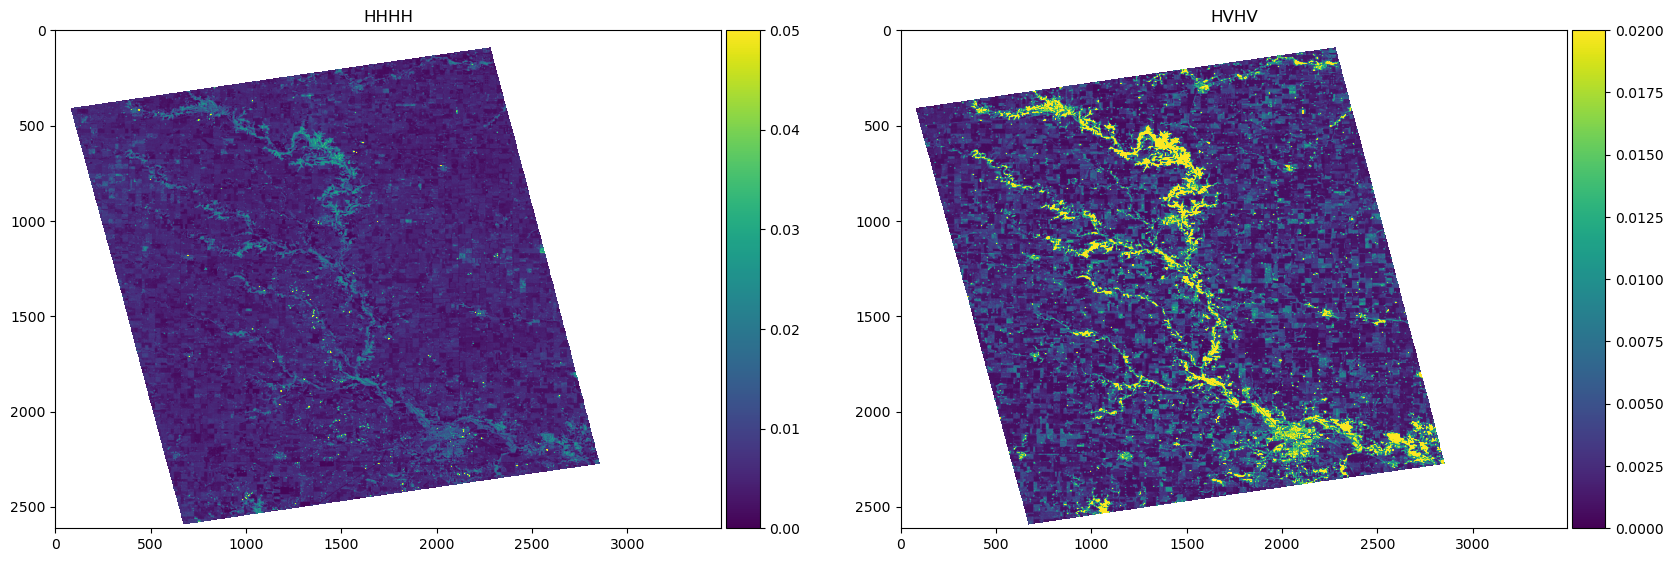

In [179]:
HH = rasterio.open('%s_subset_coreg.tif' %(tif_files[0][:-4])).read(1)
HV = rasterio.open('%s_subset_coreg.tif' %(tif_files[1][:-4])).read(1)

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(20,40))
im1 = ax1.imshow(HH,vmin=0,vmax=.05)
im2 = ax2.imshow(HV,vmin=0,vmax=.02)
ax1.set_title('HHHH')
ax2.set_title('HVHV')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');